In [125]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

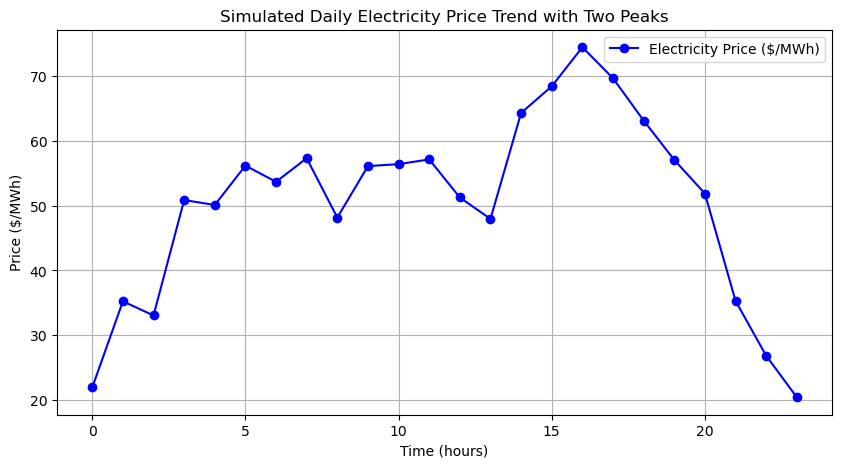

In [126]:
def generate_energy_prices(T, base_price=50, peak_amplitudes=[10,15], peak_times=[8, 18], std_dev=5):
    """
    Generate a realistic daily electricity price trend with two peaks and stochastic variations.

    Parameters:
        T (int): Number of time steps (e.g., hours).
        base_price (float): Average electricity price ($/MWh).
        peak_amplitude (float): Amplitude of price fluctuations due to demand.
        peak_times (list): List of peak electricity price hours (e.g., [8, 18] for morning and evening peaks).
        std_dev (float): Standard deviation for stochastic variations.

    Returns:
        np.array: Simulated electricity prices over time.
    """
    time = np.arange(T)
    
    # Sum of two sinusoidal functions for morning and evening peaks -> negative sign to make positive peaks at peak hours
    prices = (base_price 
              + peak_amplitudes[0] * -np.sin((time - peak_times[0]) * np.pi / 6)  
              + peak_amplitudes[1] * -np.sin((time - peak_times[1]) * np.pi / 12)) 
    
    # Add stochastic noise to simulate market fluctuations
    prices += np.random.normal(0, std_dev, T)
    
    # Ensure prices are non-negative -> shouldnt be neccesairy
    prices = np.clip(prices, 0, None)
    
    return prices

# Example usage
T = 24  # 24-hour simulation
prices = generate_energy_prices(T)

# Plot the simulated price trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(np.arange(T), prices, label="Electricity Price ($/MWh)", color='b', marker='o', linestyle='-')
plt.xlabel("Time (hours)")
plt.ylabel("Price ($/MWh)")
plt.title("Simulated Daily Electricity Price Trend with Two Peaks")
plt.grid(True)
plt.legend()
plt.show()

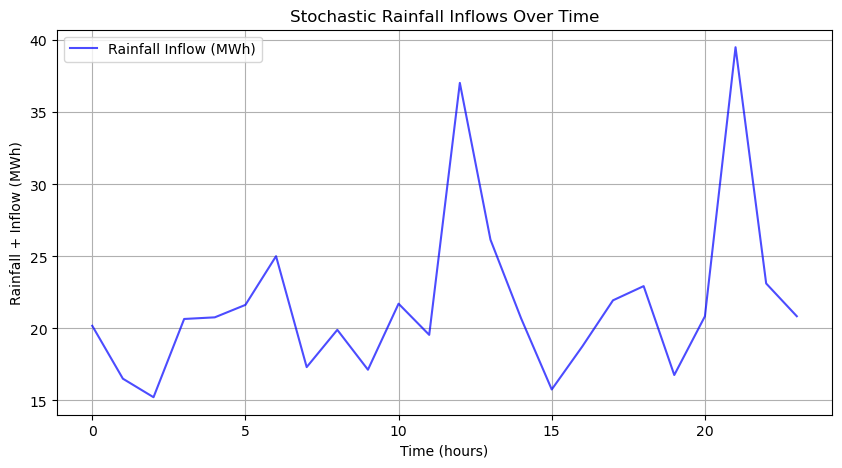

In [127]:
def stochastic_basin_inflow(T, base_inflow=20, base_std=3, avg_extra=20, rain_prob=0.03, extra_std=5):
    """
    Generate stochastic basin inflows over a given time horizon.

    Parameters:
        T (int): Number of time steps (e.g., hours).
        base_inflow (float): Average base inflow (MWh per time step).
        base_std (float): Standard deviation for the base inflow.
        avg_extra (float): Average extra inflow due to rainfall (MWh per time step).
        rain_prob (float): Probability of extra rainfall inflow occurring at each time step.
        extra_std (float): Standard deviation for the extra inflow from rainfall.

    Returns:
        np.array: Stochastic basin inflow series (MWh per time step).
    """
    # Generate the base inflow with its own stochastic variation. -> should be a function of historical data in the future
    base = np.random.normal(base_inflow, base_std, T)
    base = np.clip(base, 0, None)  # Ensure non-negative inflow
    
    # Generate extra inflow due to rainfall: binary occurrence * stochastic extra amount.
    # Not sure if neccesairy as it should be neglectable
    rain_events = np.random.binomial(1, rain_prob, T)
    extra = rain_events * np.random.normal(avg_extra, extra_std, T)
    extra = np.clip(extra, 0, None)
    
    # Total inflow is the sum of base and extra rainfall inflows.
    return base + extra
    
# Example usage
T = 24  # 24-hour simulation
rainfall_inflows = stochastic_basin_inflow(T)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(T), rainfall_inflows, color='blue', alpha=0.7, label="Rainfall Inflow (MWh)")
plt.xlabel("Time (hours)")
plt.ylabel("Rainfall + Inflow (MWh)")
plt.title("Stochastic Rainfall Inflows Over Time")
plt.legend()
plt.grid(True)
plt.show()

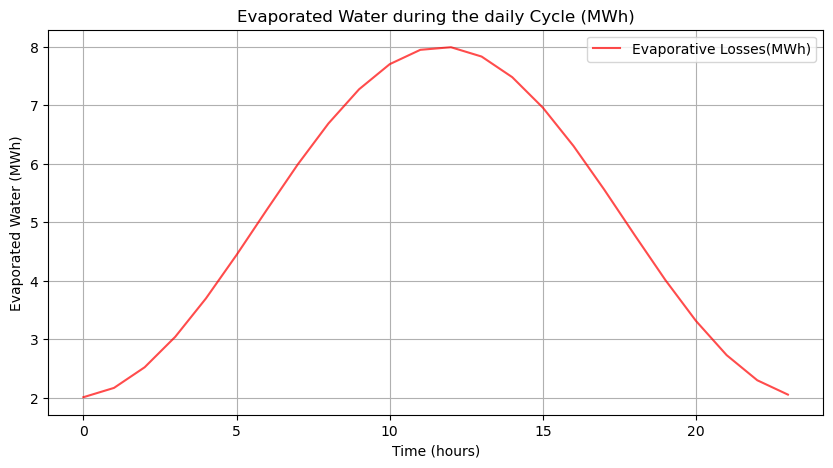

In [128]:
def evaporation_loss(T, avg_evap=5, peak_time=12, peak_amplitude=3):
    """
    Generate an approximation of evaporation loss in MWh per hour.

    Parameters:
        T (int): Number of time steps (e.g., hours).
        avg_evap (float): Average daily evaporation loss per hour (MWh).
        peak_time (int): Time (hour) when evaporation is at its maximum.
        peak_amplitude (float): Additional evaporation at peak (MWh).

    Returns:
        np.array: Hourly evaporation loss over the time horizon.
    """
    time = np.arange(T)
    
    # Sinusoidal function centered at peak_time
    evap = avg_evap + peak_amplitude * np.sin( (np.pi / 12) * (time + peak_time + 2*np.pi ) )
    
    # Ensure non-negative evaporation
    evap = np.clip(evap, 0, None)
    
    return evap

# Example usage
T = 24  # 24-hour simulation
evaporation = evaporation_loss(T)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(T), evaporation, color='red', alpha=0.7, label="Evaporative Losses(MWh)")
plt.xlabel("Time (hours)")
plt.ylabel("Evaporated Water (MWh)")
plt.title("Evaporated Water during the daily Cycle (MWh)")
plt.legend()
plt.grid(True)
plt.show()

In [129]:
# Time horizon (e.g., 24 hours)
T = 24


reservoir_capacity = 1000   # Maximum storage in MWh
initial_storage = 600       # Initial storage level (MWh)
S_min = 100                 # Minimum storage level (MWh)
pump_max = 100              # Max pumping power (MW)
gen_max = 100               # Max generation power (MW)

pump_efficiency = 0.9       # Pumping efficiency
gen_efficiency = 0.9        # Generation efficiency


# The decision variables are:
#   p[0], p[1], ..., p[T-1]   (pumping amounts at each time step)
#   g[0], g[1], ..., g[T-1]   (generation amounts at each time step)
# They are stored in a vector z of length 2*T.
# We want:
#   0 <= p[t] <= pump_max  and  0 <= g[t] <= gen_max for all t

#generate a stochastic daily energy price
prices = generate_energy_prices(T, base_price=50, peak_amplitudes=[15,20], peak_times=[8, 18], std_dev=5)

# Generate stochastic  inflows in MWh per timestep
evaporation = evaporation_loss(T, avg_evap=5, peak_time=12, peak_amplitude=3)
inflows = stochastic_basin_inflow(T, base_inflow=20, base_std=3, avg_extra=20, rain_prob=0.03, extra_std=5) - evaporation

The goal is to maximize profit, which is calculated as the sum of (generation * price) - (pumping * price) over all time steps. Since minimize() minimizes, the negative of the profit is used.

In [131]:
# Objective: maximize profit = sum_t [price[t]*(g[t] - p[t])]
# Since minimize() minimizes, we use the negative profit.
def objective(z):
    p = z[:T]
    g = z[T:]
    return -np.sum(prices * (g - p))
    
# Compute storage trajectory based on decisions z
def compute_storage(z):
    p = z[:T]
    g = z[T:]
    # Storage dynamics: S[t+1] = S[t] + pump_efficiency * p[t] - g[t] / gen_efficiency + inflow  -> changed to g[t] * eff
    S = [initial_storage]
    for t in range(T):
        S.append(S[-1] + pump_efficiency * p[t] - gen_efficiency * g[t] + inflows[t])
    return np.array(S)
      

# Define constraints: storage limits and cyclic operation 
constraints = []

# 1. For each time step t=1,...,T, storage must be between 0 and reservoir_capacity.
for t in range(1, T+1):
   # Lower bound: S[t] >= S_min  --> S[t] - S_min >= 0
    constraints.append({
        'type': 'ineq',
        'fun': lambda z, t=t: compute_storage(z)[t] - S_min
    })
    # Upper bound: reservoir_capacity - S[t] >= 0  --> S[t] <= reservoir_capacity
    constraints.append({
        'type': 'ineq',
        'fun': lambda z, t=t: reservoir_capacity - compute_storage(z)[t]
    })

# 2.  enforce cyclic operation: final storage equals initial storage.
constraints.append({
    'type': 'eq',
    'fun': lambda z: compute_storage(z)[-1] - initial_storage
})

# Bounds for decision variables:
# p in [0, pump_max] for t=0,...,T-1 and g in [0, gen_max] for t=0,...,T-1.
bounds = [(0, pump_max)] * T + [(0, gen_max)] * T

# Initial guess: zeros for all decisions
z0 = np.zeros(2 * T)

# Solve the optimization problem using SLSQP(Sequential quadratic programming)
result = minimize(objective, z0, method='SLSQP', bounds=bounds, constraints=constraints)

if result.success:
    z_opt = result.x
    p_opt = z_opt[:T]
    g_opt = z_opt[T:]
    S_opt = compute_storage(z_opt)
    total_profit = -objective(z_opt)
    print("Optimization converged.")
    print("Total Daily Profit: €", round(total_profit, 2))

else:
    print("Optimization did not converge.")

Optimization converged.
Total Daily Profit: € 54490.44


In [132]:
def conversion_factor(A, rho=1000, g=9.81):
    """
    Computes conversion factor from energy (MWh) to water depth (m).
    1 MWh = 3.6e9 Joules, so:
    k = (3.6e9 J/MWh) / (rho*g*A)  [m/MWh]
    """
    return 3.6e9 / (rho * g * A)

k = conversion_factor(1e6)

water_depth = S_opt * k
inflow_depth = inflows * k
evap_depth = evaporation * k

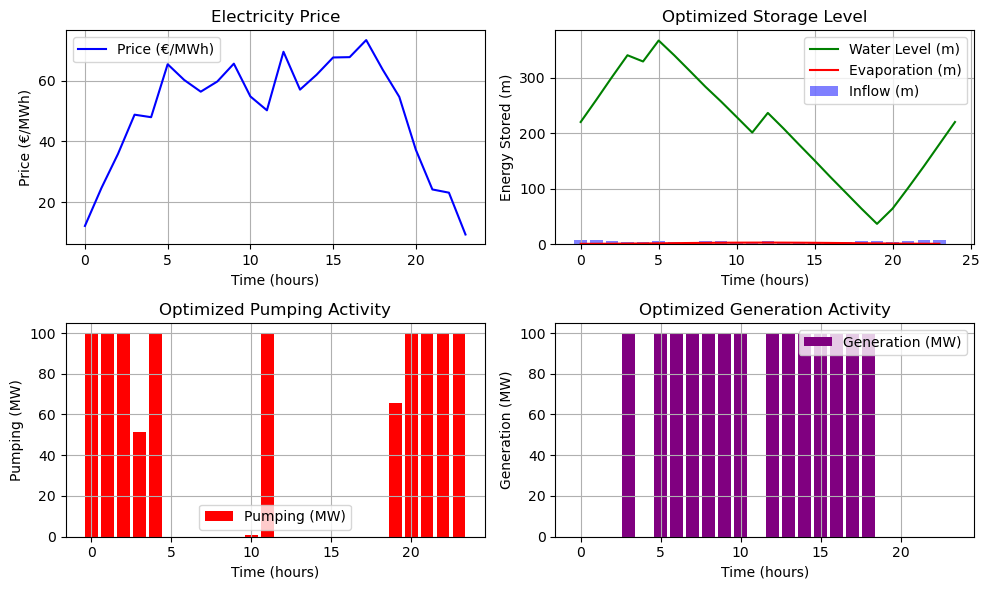

In [133]:
# Create a time vector for plotting
time = np.arange(T)

# Plot price series
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(time, prices, label="Price (€/MWh)", color='b',  linestyle='-')
plt.xlabel("Time (hours)")
plt.ylabel("Price (€/MWh)")
plt.title("Electricity Price")
plt.grid(True)
plt.legend()

# Plot optimized storage levels
plt.subplot(2, 2, 2)
plt.plot(np.arange(T+1), water_depth, label="Water Level (m)", color='g', linestyle='-')
plt.plot(np.arange(T), evap_depth, label="Evaporation (m)", color='r', linestyle='-')
plt.bar(time, inflow_depth, label="Inflow (m)", color='blue', alpha=0.5)
plt.xlabel("Time (hours)")
plt.ylabel("Energy Stored (m)")
plt.title("Optimized Storage Level")
plt.grid(True)
plt.legend()

# Plot optimized pumping decisions
plt.subplot(2, 2, 3)
plt.bar(time, p_opt, label="Pumping (MW)", color='r')
plt.xlabel("Time (hours)")
plt.ylabel("Pumping (MW)")
plt.title("Optimized Pumping Activity")
plt.grid(True)
plt.legend()

# Plot optimized generation decisions
plt.subplot(2, 2, 4)
plt.bar(time, g_opt, label="Generation (MW)", color='purple')
plt.xlabel("Time (hours)")
plt.ylabel("Generation (MW)")
plt.title("Optimized Generation Activity")
plt.grid(True)
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Possible improvements:
- Currently, **pump_efficiency and gen_efficiency are constant**. In reality, they vary with power output and head (water level). Implementing functions that model these variations.
- The head (water level) affects both generation and pumping. Incorporate **head-dependent generation and pumping rates**. This requires modeling the reservoir's geometry and its relationship to head.
- Accounting for **seasonal variations** and weather patterns in inflow modeling.
- Instead of assuming a linear relationship between stored energy and water level, a more realistic representation based on the **actual reservoir geometry** could be used.
- Utilizing NumPy's vectorized operations to **improve performance**, especially in the compute_storage() function.